<a href="https://colab.research.google.com/github/JSJeong-me/Machine_Learning/blob/main/ML/10-pytorch-cartpole_dqn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1


In [2]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1

In [3]:
%matplotlib inline

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

In [5]:
import gym
from gym import wrappers
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image

from IPython import display as ipythondisplay

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

In [6]:
from gym.version import VERSION
print(VERSION)

0.17.3


In [7]:
env = gym.make('CartPole-v0')
env = gym.wrappers.Monitor(env, 'drive/MyDrive/Colab Notebooks/videos', force = True, video_callable=lambda episode_id: episode_id%10==0)
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
  from IPython import display

plt.ion()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))
# Transition: Replay Memory에 삽입되는 데이터의 최소형태

class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0
# capacity: Replay Memory의 사이즈 
# 기본적으로는 python list의 형태

    def push(self, *args):
      
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity
  
# push: Replay Memory에 Transition을 밀어넣음
# Replay Memory 크기가 capacity보다 작을 때는 추가하는 것에서 그치지만,
# capacity보다 커졌을 때는 position의 위치에 신규 transition을 넣는다.
# 새로운 transition이 삽입되면 position = {(position + 1)을 capacity로 나눠준 결과의 나머지}
# append 함수는 리스트의 끝에 원소를 삽입하므로,
# 리스트가 capacity만큼 커진 뒤 처음으로 삭제되는 원소는 제일 처음에 삽입했던 원소가 된다. (fisrt in first out)
# 다음으로 들어오는 transition은 1의 위치에 삽입, 
# position이 가리키는 정수가 capacity만큼 커지면, 자동으로 0으로 돌아감(capcity로 나눠준 결과의 '나머지'를 활용하므로)


    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
# sample 함수는 'memory'에서 'batch_size'만큼의 원소를 추출해줌


    def __len__(self):
        return len(self.memory)

In [9]:
class DQN(nn.Module):
  def __init__(self, h, w, outputs):
    super(DQN, self).__init__()
    self.conv1 = nn.Conv2d(3, 16, kernel_size = 5, stride = 2)
    self.bn1 = nn.BatchNorm2d(16)
    self.conv2 = nn.Conv2d(16, 32, kernel_size = 5, stride = 2)
    self.bn2 = nn.BatchNorm2d(32)
    self.conv3 = nn.Conv2d(32, 32, 5, 2)
    self.bn3 = nn.BatchNorm2d(32)

# 구조: 
# Conv1:  3개의 인풋채널 -> 16개의 5x5 커널, stride 2 -> 16개의 채널 
# Conv2: 16개의 인풋채널 -> 32개의 5x5 커널, stride 2 -> 32개의 채널
# Conv3: 32개의 인풋채널 -> 32개의 5x5 커널, stride 2 -> 32개의 채널

# Conv Layer 최종 결과:
# 32개 채널의 convw * convh 크기 output

    def conv2d_size_out(size, kernel_size = 5, stride = 2):
      return (size - (kernel_size-1) -1)//stride + 1
    convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
    convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
    linear_input_size = convw*convh*32
    self.head = nn.Linear(linear_input_size, outputs)

  def forward(self, x):
    x = F.relu(self.bn1(self.conv1(x)))
    x = F.relu(self.bn2(self.conv2(x)))
    x = F.relu(self.bn3(self.conv3(x)))
    return self.head(x.view(x.size(0), -1))

    

In [10]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 300))
display.start()

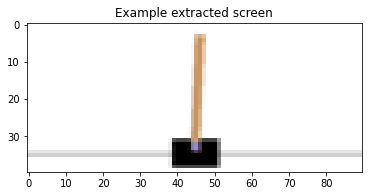

In [11]:
resize = T.Compose([T.ToPILImage(),
                    T.Resize(40, interpolation=Image.CUBIC),
                    T.ToTensor()])

# T: torchvision transform은 이미지 변형에 사용됨
# PIL image를 입력받은 뒤 적절하게 변형하여 tensor로 바꿈

def get_cart_location(screen_width):
    world_width = env.x_threshold * 2
    scale = screen_width / world_width
    return int(env.state[0] * scale + screen_width / 2.0)  # MIDDLE OF CART

# cart의 위치 구하기
# cart 가로 사이즈: world width
# scale: 카트 대비 스크린의 크기
# env.state: 카트 이동 거리(카트 크기 기준)
# 카트 위치: 카트 이동 거리*scale + 스크린 중간

def get_screen():
    screen = env.render(mode='rgb_array').transpose((2, 0, 1))
    _, screen_height, screen_width = screen.shape
    screen = screen[:, int(screen_height*0.4):int(screen_height * 0.8)]
# 카트가 화면 아래쪽에 위치하므로 화면 크기를 줄일 수 있음
    view_width = int(screen_width * 0.6)
    cart_location = get_cart_location(screen_width)
    if cart_location < view_width // 2:
        slice_range = slice(view_width)
    elif cart_location > (screen_width - view_width // 2):
        slice_range = slice(-view_width, None)
    else:
        slice_range = slice(cart_location - view_width // 2,
                            cart_location + view_width // 2)
    screen = screen[:, :, slice_range]
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    return resize(screen).unsqueeze(0).to(device)


env.reset()
plt.figure()
plt.imshow(get_screen().cpu().squeeze(0).permute(1, 2, 0).numpy(),
           interpolation='none')
ipythondisplay.clear_output(wait=True)
plt.title('Example extracted screen')
plt.show()

In [12]:
device

device(type='cuda')

In [13]:
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10

init_screen = get_screen()
_, _, screen_height, screen_width = init_screen.shape

n_actions = env.action_space.n
# gym action space가 보유한 '행동'

policy_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters())
memory = ReplayMemory(10000)

steps_done = 0

def select_action(state):
  global steps_done
  sample = random.random()
  eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1.*steps_done/EPS_DECAY)
  steps_done += 1
  if sample > eps_threshold:
    with torch.no_grad():
      return policy_net(state).max(1)[1].view(1,1)
# 1- eps_threshold 의 확률로 최선의 행동을 선택
# policy_net(state): 각 state에 대한 행동에 따른 보상
# t.max(1)[1]: 행동 중 가장 큰 보상과 index 
  else:
    return torch.tensor([[random.randrange(n_actions)]], device = device, dtype = torch.long)
  
episode_durations = []
# episode durations 리스트 형성

def plot_durations():
  plt.figure(2)
  plt.clf()
  durations_t = torch.tensor(episode_durations, dtype = torch.float)
# durations_t 는 episode durations 리스트를 tensor로 만들어 줌

  plt.title('Training')
  plt.xlabel('Episode')
  plt.ylabel('Duration')

  plt.plot(durations_t.numpy())

  if len(durations_t) >= 100:
    means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
    means = torch.cat((torch.zeros(99), means))
    plt.plot(means.numpy())
# durations_t의 원소 개수가 100을 넘어가면 == 에피소드가 100을 넘으면
# 평균값을 새로 plot에 추가

  plt.pause(0.001)
  if is_ipython:
    ipythondisplay.clear_output(wait = True)
    # ipythondisplay.display(plt.gcf())

episode_rewards = []

def plot_rewards():
    plt.figure(3)
    plt.clf()
    reward_t = torch.tensor(episode_rewards, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(reward_t.numpy())
    # Take 100 episode averages and plot them too
    if len(reward_t) >= 100:
        means = reward_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        ipythondisplay.clear_output(wait=True)
        # display.display(plt.gcf())

In [14]:
def optimize_model():
  if len(memory) < BATCH_SIZE:
    return

# memory 가 batch_size 이상만큼 쌓였을 때 시작
# 참고로 memory capcity는 10000, batch_size 는 128

  transitions = memory.sample(BATCH_SIZE)

  batch = Transition(*zip(*transitions))
# memory에서 추출된 샘플들을 또 한데 모음
# 한데 모은 샘플들은 하나의 tensor로 병합될 예정 (마지막 state 빼고)
# 참고로, 샘플의 형식은 (State, Action, Next State, Reward)

  non_final_mask = torch.tensor(tuple(map(lambda s: s != None, batch.next_state)), device = device, dtype = torch.bool)
# 현재 state가 final state가 아님을 보장해주는 필터
  non_final_next_states = torch.cat([s for s in batch.next_state if s != None])
# Next state가 final state가 아님을 보장해주는 필터

  state_batch = torch.cat(batch.state)
  action_batch = torch.cat(batch.action)
  reward_batch = torch.cat(batch.reward)

# Loss 계산: (Q - expected Q) 최소화
  state_action_values = policy_net(state_batch).gather(1, action_batch)
# gather의 역할:

  next_state_values = torch.zeros(BATCH_SIZE, device = device)
  next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
# mask 사용법:
# detach의 역할
  expected_state_action_values = (next_state_values * GAMMA) + reward_batch
# Expected Q: r + gamma * max_a(Q')

  loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

  optimizer.zero_grad()
  loss.backward()
  for param in policy_net.parameters():
    param.grad.data.clamp_(-1, 1)
  optimizer.step()


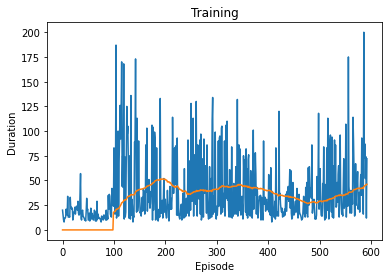

In [ ]:
num_episodes = 1000
for i_episode in range(num_episodes):
  env.reset()
  last_screen = get_screen()
  current_screen = get_screen()
  state = current_screen - last_screen
  for t in count():
    action = select_action(state)
    _, reward, done, _ = env.step(action.item())
    reward = torch.tensor([reward], device = device)
# State에 대한 reward는 언제나 1인데,
# incremental timestep을 cartpole이 균형을 잡고 있는 동안은 무조건 보상이 주어지고
# cartpole이 균형을 잃을 경우 에피소드가 종료되기 때문


    last_screen = current_screen
    current_screen = get_screen()
    if not done:
      next_state = current_screen - last_screen
    else:
      next_state = None

    memory.push(state, action, next_state, reward)

    state = next_state

    optimize_model()
    if done:
      episode_durations.append(t + 1)
      episode_rewards.append(reward)
      plot_durations()
      break
    
  if i_episode % TARGET_UPDATE == 0:
    target_net.load_state_dict(policy_net.state_dict())


print('Complete')
env.render()
env.close
plt.ioff()
plt.show()


In [ ]:
import base64
import glob
import io
import os

from IPython.display import HTML, display


def ipython_show_video(path: str) -> None:
    """Show a video at `path` within IPython Notebook."""
    if not os.path.isfile(path):
        raise NameError("Cannot access: {}".format(path))

    video = io.open(path, "r+b").read()
    encoded = base64.b64encode(video)

    display(HTML(
        data="""
        <video alt="test" controls>
        <source src="data:video/mp4;base64,{0}" type="video/mp4"/>
        </video>
        """.format(encoded.decode("ascii"))
    ))

list_of_files = glob.glob("drive/MyDrive/Colab Notebooks/videos/*.mp4")
latest_file = max(list_of_files, key=os.path.getctime)
print(latest_file)
print(os.path.getctime(latest_file))
ipython_show_video(latest_file)


In [ ]:
env.close()
